## Multiple Linear Regression
### and backward elimination
#### infrastructure indicators

The purpose of this notebook is to 
* apply Multiple Linear Regression to the preprocessed dataset
* apply backward elimination to the model
* ultimately find out the independent variables (World Development Idicators) which influence the dependent variable (Happy Planet Index) the most.

The model will be applied to the "wdi_hpi_2016_infrastructure" dataset, which was created in the Data Preprocessing JNotebook. This dataset is based on
* the Happy Planet Index for 2016 (see https://happyplanetindex.org/),
* the World Development Indicators (1960 - 2019) by the World Bank (see https://datacatalog.worldbank.org/dataset/world-development-indicators)

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import dataset
dataset = pd.read_pickle('../data/wdi_hpi_2016_infrastructure.pkl')
picture_name = '../data/pictures/Infrastructure_corr.jpg'

In [3]:
# Standardize data for the model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit dataset to scaler object
dataset_scaled = dataset.iloc[:, 1:].values    # Exclude Country column 
scaler.fit(dataset_scaled)

# Transform data into scaled data
dataset_scaled = pd.DataFrame(scaler.transform(dataset_scaled))

In [4]:
# Split dataset into X (matrix of independent variables) and y (vector of dependent variable)
X = dataset_scaled.iloc[:, 1:-1].values
y = dataset_scaled.iloc[:, dataset_scaled.shape[1]-1].values

# Split datasets into Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.0)    # no split, as model is not used for prediction

In [5]:
# Fit Multiple Linear Regression Model to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
# Predict the Test set results
#y_pred = regressor.predict(X_test)

In [7]:
# Reduce less important variables with Backward Elimination
import statsmodels.regression.linear_model as sm

# for statsmodel to understand the multiple linear regression equation a new column with b0 equals one is required (y = b0 + b1*x1 + b2*x2 + ... + bn*xn)
X_opt = np.append(arr = np.ones((len(X), 1)).astype(int), values = X, axis = 1)   # Add X to the newly created array of 1s
#X_opt = X_opt[:, list(range(X_opt.shape[1]))]

X_cols = dataset.columns[1:-1].tolist()    # save headers to determin most important variables later
X_cols.insert(0,'b0')

X_mod1, X_mod2 = X_opt.copy(), X_opt.copy()
X_cols_mod1, X_cols_mod2 = X_cols.copy(), X_cols.copy()

regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     12.13
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           2.50e-15
Time:                        17:19:24   Log-Likelihood:                -147.33
No. Observations:                 139   AIC:                             318.7
Df Residuals:                     127   BIC:                             353.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.012e-16      0.062  -3.25e-15      1.000      -0.123       0.123
x1            -0.0514      0.088     -0.586      0.559      -0.225       0.122
x2            -0.2268      0.079     -2.870      0.005      -0.383      -0.070
x3             0.0887      0.064      1.384      0.169      -0.038       0.216
x4            -0.0868      0.081     -1.070      0.286      -0.247       0.074
x5            -0.2270      0.157     -1.449      0.150      -0.537       0.083
x6            -0.2688      0.168     -1.597      0.113      -0.602       0.064
x7             0.2182      0.147      1.489      0.139      -0.072       0.508
x8            -0.2162      0.083     -2.614      0.010      -0.380      -0.053
x9             0.0474      0.091      0.519      0.605      -0.133       0.228
x10           -0.2195      0.163     -1.348      0.180      -0.542       0.103
x11            1.2091      0.162      7.485      0.000       0.889       1.529
==============================================================================
Omnibus:                        1.868   Durbin-Watson:                   2.314
Prob(Omnibus):                  0.393   Jarque-Bera (JB):                1.495
Skew:                          -0.068   Prob(JB):                        0.474
Kurtosis:                       2.511   Cond. No.                         8.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# Fuction to automatically remove columns where P-value is below significance level of 5%
def backward_elimination(x, X_cols_mod, significance = 0.05):
    num_vars = len(x[0])
    for i in range(0, num_vars):
        regressor_OLS = sm.OLS(endog = y, exog = x).fit()
        max_var = max(regressor_OLS.pvalues).astype(float)
        if max_var > significance:
            for j in range(0, num_vars - i):
                if (regressor_OLS.pvalues[j].astype(float) == max_var):
                    x = np.delete(x, j, 1)
                    X_cols_mod.pop(j)
    regressor_OLS.summary()
    return x, X_cols_mod
             
backward_elimination(X_mod1, X_cols_mod1)
print(X_cols_mod1)

['FB.ATM.TOTL.P5', 'IT.CEL.SETS.P2', 'SH.H2O.BASW.ZS', 'SH.STA.BASS.ZS', 'SP.DYN.LE00.IN']


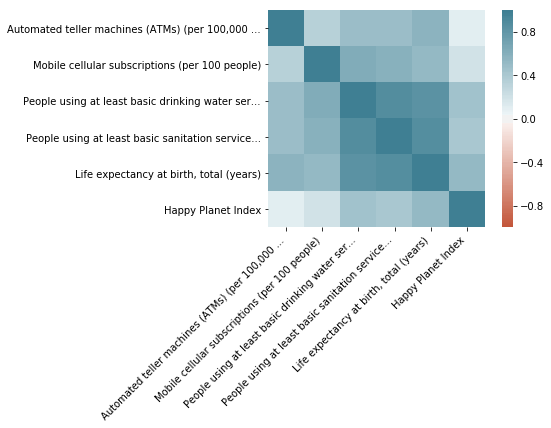

In [9]:
# Create Correlation Matrix with Seaborn (only remaining columns from backward elimination)

# Translate WDI abbreviations into meaningsful indicator descriptions
chosen_columns = pd.read_pickle('../data/WDI_chosen_columns.pkl')

corr_cols_descr = []
for ind in X_cols_mod1:
    descr = chosen_columns['Indicator Name'][chosen_columns['Indicator Code'] == ind].to_string(index = False)
    corr_cols_descr.append(descr)
corr_cols_descr.append('Happy Planet Index')

# Import Seaborn and plot Correlation Matrix
import seaborn as sns

corr_cols = X_cols_mod1.copy()
corr_cols.append('Happy Planet Index')
corr = dataset[corr_cols].corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    yticklabels = corr_cols_descr,
    xticklabels = corr_cols_descr
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [10]:
# Fuction to automatically remove columns where P-value is below significance level of 5%
# and adjusted R² is improved
def backward_elimination_r2(x, X_cols_mod, significance = 0.05):
    num_vars = len(x[0])
    temp = np.zeros((x.shape)).astype(int)
    for i in range(0, num_vars):
        regressor_OLS = sm.OLS(endog = y, exog = x).fit()
        max_var = max(regressor_OLS.pvalues).astype(float)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if max_var > significance:
            for j in range(0, num_vars - i):
                if (regressor_OLS.pvalues[j].astype(float) == max_var):
                    temp[:,j] = x[:, j]
                    x = np.delete(x, j, axis = 1)
                    tmp_col = X_cols_mod.pop(j)
                    tmp_regressor = sm.OLS(endog = y, exog = x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):
                        x_rollback = np.hstack((x, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        X_cols_rollback = X_cols_mod.append(tmp_col)
                        #x = np.hstack((x, temp[:,[0,j]]))
                        #x = np.delete(x, j, 1)
                        #X_cols_mod = X_cols_mod.append(tmp_col)
                        print (regressor_OLS.summary())
                        return x_rollback, X_cols_rollback
                    else:
                        continue
    regressor_OLS.summary()
    return x, X_cols_mod
    
backward_elimination_r2(X_mod2, X_cols_mod2)
print(X_cols_mod2)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     15.03
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           1.56e-16
Time:                        17:19:24   Log-Likelihood:                -147.65
No. Observations:                 139   AIC:                             313.3
Df Residuals:                     130   BIC:                             339.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2310      0.076     -3.027      0.0

,FB.ATM.TOTL.P5,FB.CBK.BRCH.P5,IT.CEL.SETS.P2,IT.MLT.MAIN.P2,IT.NET.BBND.P2,SH.H2O.BASW.ZS,SH.MED.PHYS.ZS,SH.STA.BASS.ZS,SP.DYN.LE00.IN,FP.CPI.TOTL,Happy Planet Index
FB.ATM.TOTL.P5,1.000000,0.504330,0.335381,0.685491,0.626851,0.484563,0.463098,0.491248,0.571887,-0.028472,0.107514
FB.CBK.BRCH.P5,0.504330,1.000000,0.267486,0.538341,0.484352,0.443399,0.402689,0.417549,0.533914,-0.030252,0.084026
IT.CEL.SETS.P2,0.335381,0.267486,1.000000,0.445287,0.436403,0.627807,0.278390,0.592428,0.528689,-0.085611,0.193809
IT.MLT.MAIN.P2,0.685491,0.538341,0.445287,1.000000,0.887527,0.626801,0.609840,0.684047,0.776015,-0.003432,0.162410
IT.NET.BBND.P2,0.626851,0.484352,0.436403,0.887527,1.000000,0.627295,0.714040,0.665568,0.785017,-0.096131,0.185223
SH.H2O.BASW.ZS,0.484563,0.443399,0.627807,0.626801,0.627295,1.000000,0.427184,0.882600,0.829580,-0.006541,0.459057
SH.MED.PHYS.ZS,0.463098,0.402689,0.278390,0.609840,0.714040,0.427184,1.000000,0.483514,0.554315,-0.050594,0.156095
SH.STA.BASS.ZS,0.491248,0.417549,0.592428,0.684047,0.665568,0.882600,0.483514,1.000000,0.867220,0.001629,0.421342
SP.DYN.LE00.IN,0.571887,0.533914,0.528689,0.776015,0.785017,0.829580,0.554315,0.867220,1.000000,-0.059934,0.518391
FP.CPI.TOTL,-0.028472,-0.030252,-0.085611,-0.003432,-0.096131,-0.006541,-0.050594,0.001629,-0.059934,1.000000,0.065331


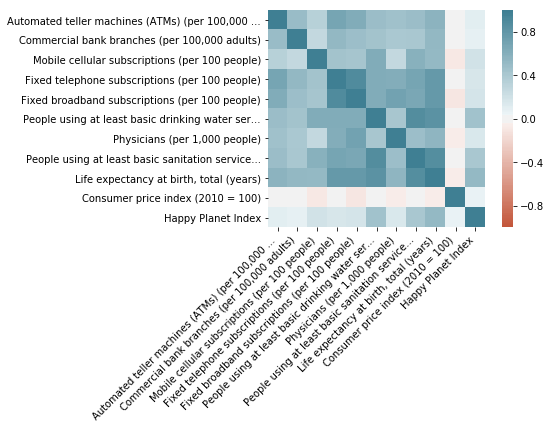

In [11]:
# Create Correlation Matrix with Seaborn

# Translate WDI abbreviations into meaningsful indicator descriptions
corr_cols_descr = []
for ind in X_cols_mod2:
    descr = chosen_columns['Indicator Name'][chosen_columns['Indicator Code'] == ind].to_string(index = False)
    corr_cols_descr.append(descr)
corr_cols_descr.append('Happy Planet Index')

corr_cols = X_cols_mod2.copy()
corr_cols.append('Happy Planet Index')
corr = dataset[corr_cols].corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    yticklabels = corr_cols_descr,
    xticklabels = corr_cols_descr
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Save Correlation Matrix to 
plt.savefig(picture_name, format = 'jpg', optimize = True, bbox_inches = 'tight')

# Return Correlation Matrix
corr